###### Intermediate State DE Genes, Overlap Between Samples

Output: Intermediate State Log2FC Analysis, Genes output

In [1]:
import os
import csv
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import openpyxl
import shutil
import subprocess
import seaborn as sns

In [2]:
currStateDir = os.getcwd()

In [ ]:
currStateDir

In [4]:
# File & folder names

currState = "Intermediate"

dataFolder = currStateDir+"/Data - Log2FC from Conditions & Genes"
outputFolder = currStateDir+"/"+currState+" State Log2FC Analysis, Genes output"
outputHistogramFolder = outputFolder+"/_Log2FC Gene Histograms Across All Conditions, Upregulated"
outputGeneExpressionFolder = outputFolder+"/Output - Upregulated "+currState+" State Genes, Log Gene Expression"

# EMT Marker directory
emtMarkerDir = os.path.dirname(currStateDir)+"/Markers"

# Percent of cells with gene expression directory
nCellsFolder = os.path.dirname(currStateDir)+"/nCells"

allConditions_fileName = "_"+currState+" State Marker Genes, All Conditions.csv"

## Import DE Gene Names

In [5]:
# Import data

os.chdir(dataFolder)
DE_genes = pd.read_csv(open(allConditions_fileName,'r'))

In [ ]:
# Each expt/condition with its list of DE genes

DE_genes.head(5)
# NaNs here are because there are not the same number of DE genes in each condition
# (using an adj-p-val cutoff, from DE genes calculation, cutting off at maximum # genes)

In [7]:
# Genes most frequently found in state

flattened_DE_genes = pd.Series(DE_genes.to_numpy().flatten())
DE_genes_union = set(flattened_DE_genes.dropna().unique())

DE_genes_frequency_counts = flattened_DE_genes.value_counts()
DE_genes_frequency_counts.head(10)

SFN         8
SDC1        8
S100A2      7
FERMT1      7
PERP        7
TXNDC17     7
ITGB4       7
PA2G4       6
HSP90AA1    6
DDX21       6
dtype: int64

In [9]:
# # For a certain gene, check which conditions it is in
# currGene = DE_genes_frequency_counts.index[0]
# DE_genes_log2FC.isin([currGene]).any(0)

## Import DE Gene Log2FCs

In [10]:
# Import data
# For every single gene, have the Log2FC of information from each expt/condition
# Using Log2FC(I state / all other states), within same experiment, to compare between experiments

os.chdir(dataFolder)
all_genes_log2FC = pd.DataFrame([]) # Create df

# Fill df with gene Log2FC values from each condition
# (These values are already output from processing datasets)
inputFiles = sorted(glob.glob(currState+" State Marker Genes - *.csv"))
for inputFile in inputFiles:
    currCondition = pd.read_csv(inputFile, header=None, index_col=0)
    currCondition.index = currCondition.index.rename("Gene") # Index must have same name aross all expt conditions
    currCondition = currCondition.rename(columns={1: inputFile[34:-4]}) # Column name is expt condition
    # Merge the new column with imported conditions
    all_genes_log2FC = all_genes_log2FC.join(currCondition, how='outer')

In [11]:
# Change order of dataframe to be same as dataset order
all_genes_log2FC = all_genes_log2FC[['1-Pastushenko_Pastushenko, I1',
                                     '1-Pastushenko_Pastushenko, I2',
                                     '2-vanDijk_TGFb-day8_rep1, I',
                                     '2-vanDijk_TGFb-day8_rep2, I',
                                     '2-vanDijk_TGFb-day10_rep1, I',
                                     '2-vanDijk_TGFb-day10_rep2, I',
                                     '2-vanDijk_Zeb1_rep1, I',
                                     '2-vanDijk_Zeb1_rep2, I',
                                     '3-Cook_A549-TGFB1, I',
                                     '3-Cook_DU145-TGFB1, I',
                                     '3-Cook_OVCA420-EGF, I',
                                     '3-Cook_OVCA420-TGFB1, I',
                                     '3-Cook_OVCA420-TNF, I']]

In [12]:
DE_genes_log2FC = all_genes_log2FC.loc[list(DE_genes_union)]

## Import % of Cells with Gene Expression

In [13]:
# Import data
# For every single gene, have the %cells information from each expt/condition
os.chdir(nCellsFolder)
all_genes_nCells = pd.DataFrame([]) # Create df

# Fill df with %cells value from each condition
# (These values are already output from scanpy code)
inputFiles = sorted(glob.glob("*- percent of cells with gene expression.csv"))
for inputFile in inputFiles:
    currCondition = pd.read_csv(inputFile, header=None, index_col=0)
    currCondition.index = currCondition.index.rename("Gene") # Index must have same name aross all expt conditions
    currCondition = currCondition.rename(columns={1: inputFile[1:-44]}) # Column name is expt condition
    # Merge the new column with imported conditions
    all_genes_nCells = all_genes_nCells.join(currCondition, how='outer')
all_genes_nCells = all_genes_nCells[all_genes_nCells.index.notnull()]
all_genes_nCells = all_genes_nCells.apply(pd.to_numeric)

# Change order of dataframe to be same as dataset order
all_genes_nCells = all_genes_nCells[['1-Pastushenko_Pastushenko',
                                     '2-vanDijk_TGFb-day8_rep1',
                                     '2-vanDijk_TGFb-day8_rep2',
                                     '2-vanDijk_TGFb-day10_rep1',
                                     '2-vanDijk_TGFb-day10_rep2',
                                     '2-vanDijk_Zeb1_rep1',
                                     '2-vanDijk_Zeb1_rep2',
                                     '3-Cook_A549-TGFB1',
                                     '3-Cook_DU145-TGFB1',
                                     '3-Cook_OVCA420-EGF',
                                     '3-Cook_OVCA420-TGFB1',
                                     '3-Cook_OVCA420-TNF']]

# Same column names as DE_genes_log2FC
all_genes_nCells = all_genes_nCells.add_suffix(', I')
all_genes_nCells.insert(loc=0, column = '1-Pastushenko_Pastushenko, I1', value = all_genes_nCells.loc[:, '1-Pastushenko_Pastushenko, I'])
all_genes_nCells.rename(columns={'1-Pastushenko_Pastushenko, I': '1-Pastushenko_Pastushenko, I2'}, inplace=True)

## Filter DE Gene Log2FCs

In [14]:
# Pre-filtering
# Filter genes to have at least certain # conditions that express a gene
min_num_conditions = 5
filtered_DE_genes_log2FC = DE_genes_log2FC.dropna(axis='rows', thresh=min_num_conditions)

# Filter condition 1
# Only keep genes that are highly upregulated in multiple intermediate conditions
n_upregulated_conditions_1 = 5
upregulation_cutoff_1 = 0.58 # log2FC of 1.5
gene_filtering_criteria_1 = filtered_DE_genes_log2FC.apply(lambda s, n: s.nlargest(n)[-1] > upregulation_cutoff_1, axis=1, n=n_upregulated_conditions_1).copy()
# code inspo: https://stackoverflow.com/questions/34518634/finding-highest-values-in-each-row-in-a-data-frame-for-python
filtered_DE_genes_log2FC = filtered_DE_genes_log2FC.loc[gene_filtering_criteria_1].copy()



# # Why have multiple filter conditions?
# # There are 4 similar TGFb conditions in van Dijk - these conditions are often up-regulated / down-regulated together

# Filter condition 2
# At least two highly upregulated conditions must not be in vanDijk-TGFb

# Only Cook & van Dijk Zeb1 & Pastushenko samples
without_vanDijkTGFb_cols = [currColumn for currColumn in filtered_DE_genes_log2FC.columns if "vanDijk_TGFb" not in currColumn]
without_vanDijkTGFb = filtered_DE_genes_log2FC[without_vanDijkTGFb_cols]

# Filter
n_upregulated_conditions_2 = 2
upregulation_cutoff_2 = 0.58
gene_filtering_criteria_2 = without_vanDijkTGFb.apply(lambda s, n: s.nlargest(n)[-1] > upregulation_cutoff_2, axis=1, n=n_upregulated_conditions_2).copy()
without_vanDijkTGFb = without_vanDijkTGFb.loc[gene_filtering_criteria_2].copy()
filtered_DE_genes_log2FC = filtered_DE_genes_log2FC.loc[without_vanDijkTGFb.index.to_list()]



# Filter condition 3
# Only keep genes that have above-mentioned upregulation + expression in more than 5% of cells in those datasets

# Perc cell expression for current list of filtered DE genes
filtered_DE_genes_nCells = all_genes_nCells.filter(filtered_DE_genes_log2FC.index, axis=0)
# Two conditions: log2FC of 0.58 and percent cell gene expression of 5%
condition_log2FC = filtered_DE_genes_log2FC.applymap(lambda x: 1 if x > 0.58 else 0)
condition_nCells = filtered_DE_genes_nCells.applymap(lambda x: 1 if x > 0.05 else 0)
gene_filtering_criteria_3_df = condition_log2FC + condition_nCells
gene_filtering_criteria_3 = gene_filtering_criteria_3_df.apply(lambda s, n: s.nlargest(n)[-1] == 2.0, axis=1, n=n_upregulated_conditions_1).copy()
# code inspo: https://stackoverflow.com/questions/34518634/finding-highest-values-in-each-row-in-a-data-frame-for-python
filtered_DE_genes_log2FC = filtered_DE_genes_log2FC.loc[gene_filtering_criteria_3].copy()



# Filter condition 4
# Only keep genes that are not highly downregulated in multiple conditions
n_downregulated_conditions = 3
downregulation_cutoff = -0.58 # log2FC of 1.5
gene_filtering_criteria_4 = filtered_DE_genes_log2FC.apply(lambda s, n: s.nsmallest(n)[-1] > downregulation_cutoff, axis=1, n=n_downregulated_conditions).copy()
# code inspo: https://stackoverflow.com/questions/34518634/finding-highest-values-in-each-row-in-a-data-frame-for-python
filtered_DE_genes_log2FC = filtered_DE_genes_log2FC.loc[gene_filtering_criteria_4].copy()

In [15]:
# Overall: 5 total samples upregulated, and at least 2 must be non van Dijk TGFb
len(filtered_DE_genes_log2FC.index)

32

In [ ]:
filtered_DE_genes_log2FC.index

Index(['S100A2', 'SNHG3', 'WNT9A', 'MYC', 'RIN1', 'IL6R', 'NRG1', 'TLDC1',
       'CBFB', 'SLC35F3', 'SOCS1', 'UPP1', 'LINC01503', 'TRIM47', 'ITGA6',
       'PLEK2', 'FOSL1', 'FAM111A', 'ITGB4', 'SNX29', 'SORL1', 'ZNF385A',
       'SNCG', 'ST3GAL5', 'ARL4C', 'TINAGL1', 'SLC23A2', 'PYGL', 'SFN', 'MT2A',
       'IL4R', 'TNS4'],
      dtype='object', name='Gene')

## Graph Filtered DE Gene Log2FCs

In [17]:
# Function - graph bar plot of Log2FC for an input gene

# Rename columns for graph labels
DE_genes_log2FC_columnsRenamed = DE_genes_log2FC.rename(columns = {'1-Pastushenko_Pastushenko, I1' : 'Mouse SCC, in vivo (I1)',
                                                                   '1-Pastushenko_Pastushenko, I2' : 'Mouse SCC, in vivo (I2)',
                                                                   '2-vanDijk_TGFb-day8_rep1, I' : 'HMLE stim. TGFb (8d)',
                                                                   '2-vanDijk_TGFb-day8_rep2, I' : 'HMLE stim. TGFb (8d)',
                                                                   '2-vanDijk_TGFb-day10_rep1, I' : 'HMLE stim. TGFb (10d)',
                                                                   '2-vanDijk_TGFb-day10_rep2, I' : 'HMLE stim. TGFb (10d)',
                                                                   '2-vanDijk_Zeb1_rep1, I' : 'HMLE stim. Zeb1',
                                                                   '2-vanDijk_Zeb1_rep2, I' : 'HMLE stim. Zeb1',
                                                                   '3-Cook_A549-TGFB1, I' : 'A549 stim. TGFb',
                                                                   '3-Cook_DU145-TGFB1, I' : 'DU145 stim. TGFb',
                                                                   '3-Cook_OVCA420-EGF, I' : 'OVCA420 stim. EGF',
                                                                   '3-Cook_OVCA420-TGFB1, I' : 'OVCA420 stim. TGFb',
                                                                   '3-Cook_OVCA420-TNF, I' : 'OVCA420 stim. TNF'})   

# Annotate conditions without the gene with "NE"
def add_value_labels(ax, currGeneValues):
# code inspo: https://stackoverflow.com/questions/28931224/adding-value-labels-on-a-matplotlib-bar-chart
    
    # Spacing to look nicer on the graph
    if min(currGeneValues.dropna()) < 0:
        spacing = -3
    else:
        spacing = 3
        
    # Iterate through each bar
    for idx, rect in enumerate(ax.patches):
        # If value is NaN, then add "NE" label
        if np.isnan(currGeneValues[idx]):
            # Get X and Y placement of label from rect
            y_value = rect.get_height()
            x_value = rect.get_x() + rect.get_width() / 2
            # Create annotation
            ax.annotate(
                "N.E.",                       
                (x_value, y_value),         # Place label at end of the bar
                xytext=(0, spacing),        # Vertically shift label by custom spacing
                textcoords="offset points", # Interpret `xytext` as offset in points
                ha='center')                # Horizontally center label

In [61]:
svgDir = os.path.dirname(os.path.dirname(currStateDir))+"/Paper Figures/Illustrator base svgs/"

In [65]:
# Function - graph bar plot of Log2FC for an input gene

# Drop the lower Pastushenko value
DE_genes_log2FC_columnsRenamed_svgOutput = DE_genes_log2FC_columnsRenamed.drop("Mouse SCC, in vivo (I2)", axis=1)

def plot_Log2FC_gene_svgOutput(currGene = "S100A2"):
    os.chdir(svgDir)
    
    # Custom markers
    black_1_value = [(0.4, 0.4, 0.4, 1.)]
    purple_6_values = plt.get_cmap('Purples')(np.linspace(0.3, 0.95, 6))
    purple_6_values_tuples = list(map(tuple, purple_6_values))
    green_5_values = plt.get_cmap('Greens')(np.linspace(0.3, 0.95, 5))
    green_5_values_tuples = list(map(tuple, green_5_values))
    colors_all = black_1_value + purple_6_values_tuples + green_5_values_tuples
    
    plt.figure(figsize = (8,8), dpi=300)
    ax = DE_genes_log2FC_columnsRenamed_svgOutput.loc[currGene].plot(kind='bar', color=colors_all, width=0.8, align='center')
    # Custom funtion to add "NE"
    add_value_labels(ax, DE_genes_log2FC_columnsRenamed_svgOutput.loc[currGene])
    plt.grid(axis='x', linewidth=0.3)
    plt.title("Log2FC of "+currGene+" in EMT "+currState+" States\n", fontsize=18)
    plt.ylabel("Log2FC", fontsize=14)
    plt.xticks(rotation=45, ha="right")
    ax.set_ylim([-1.2, 2.9])
    plt.tight_layout()
    # plt.show()
    # plt.savefig(currGene+" Histogram of Log2FC.png")
    # plt.close("all");
    plt.savefig("figure-2d-"+currGene+".svg")

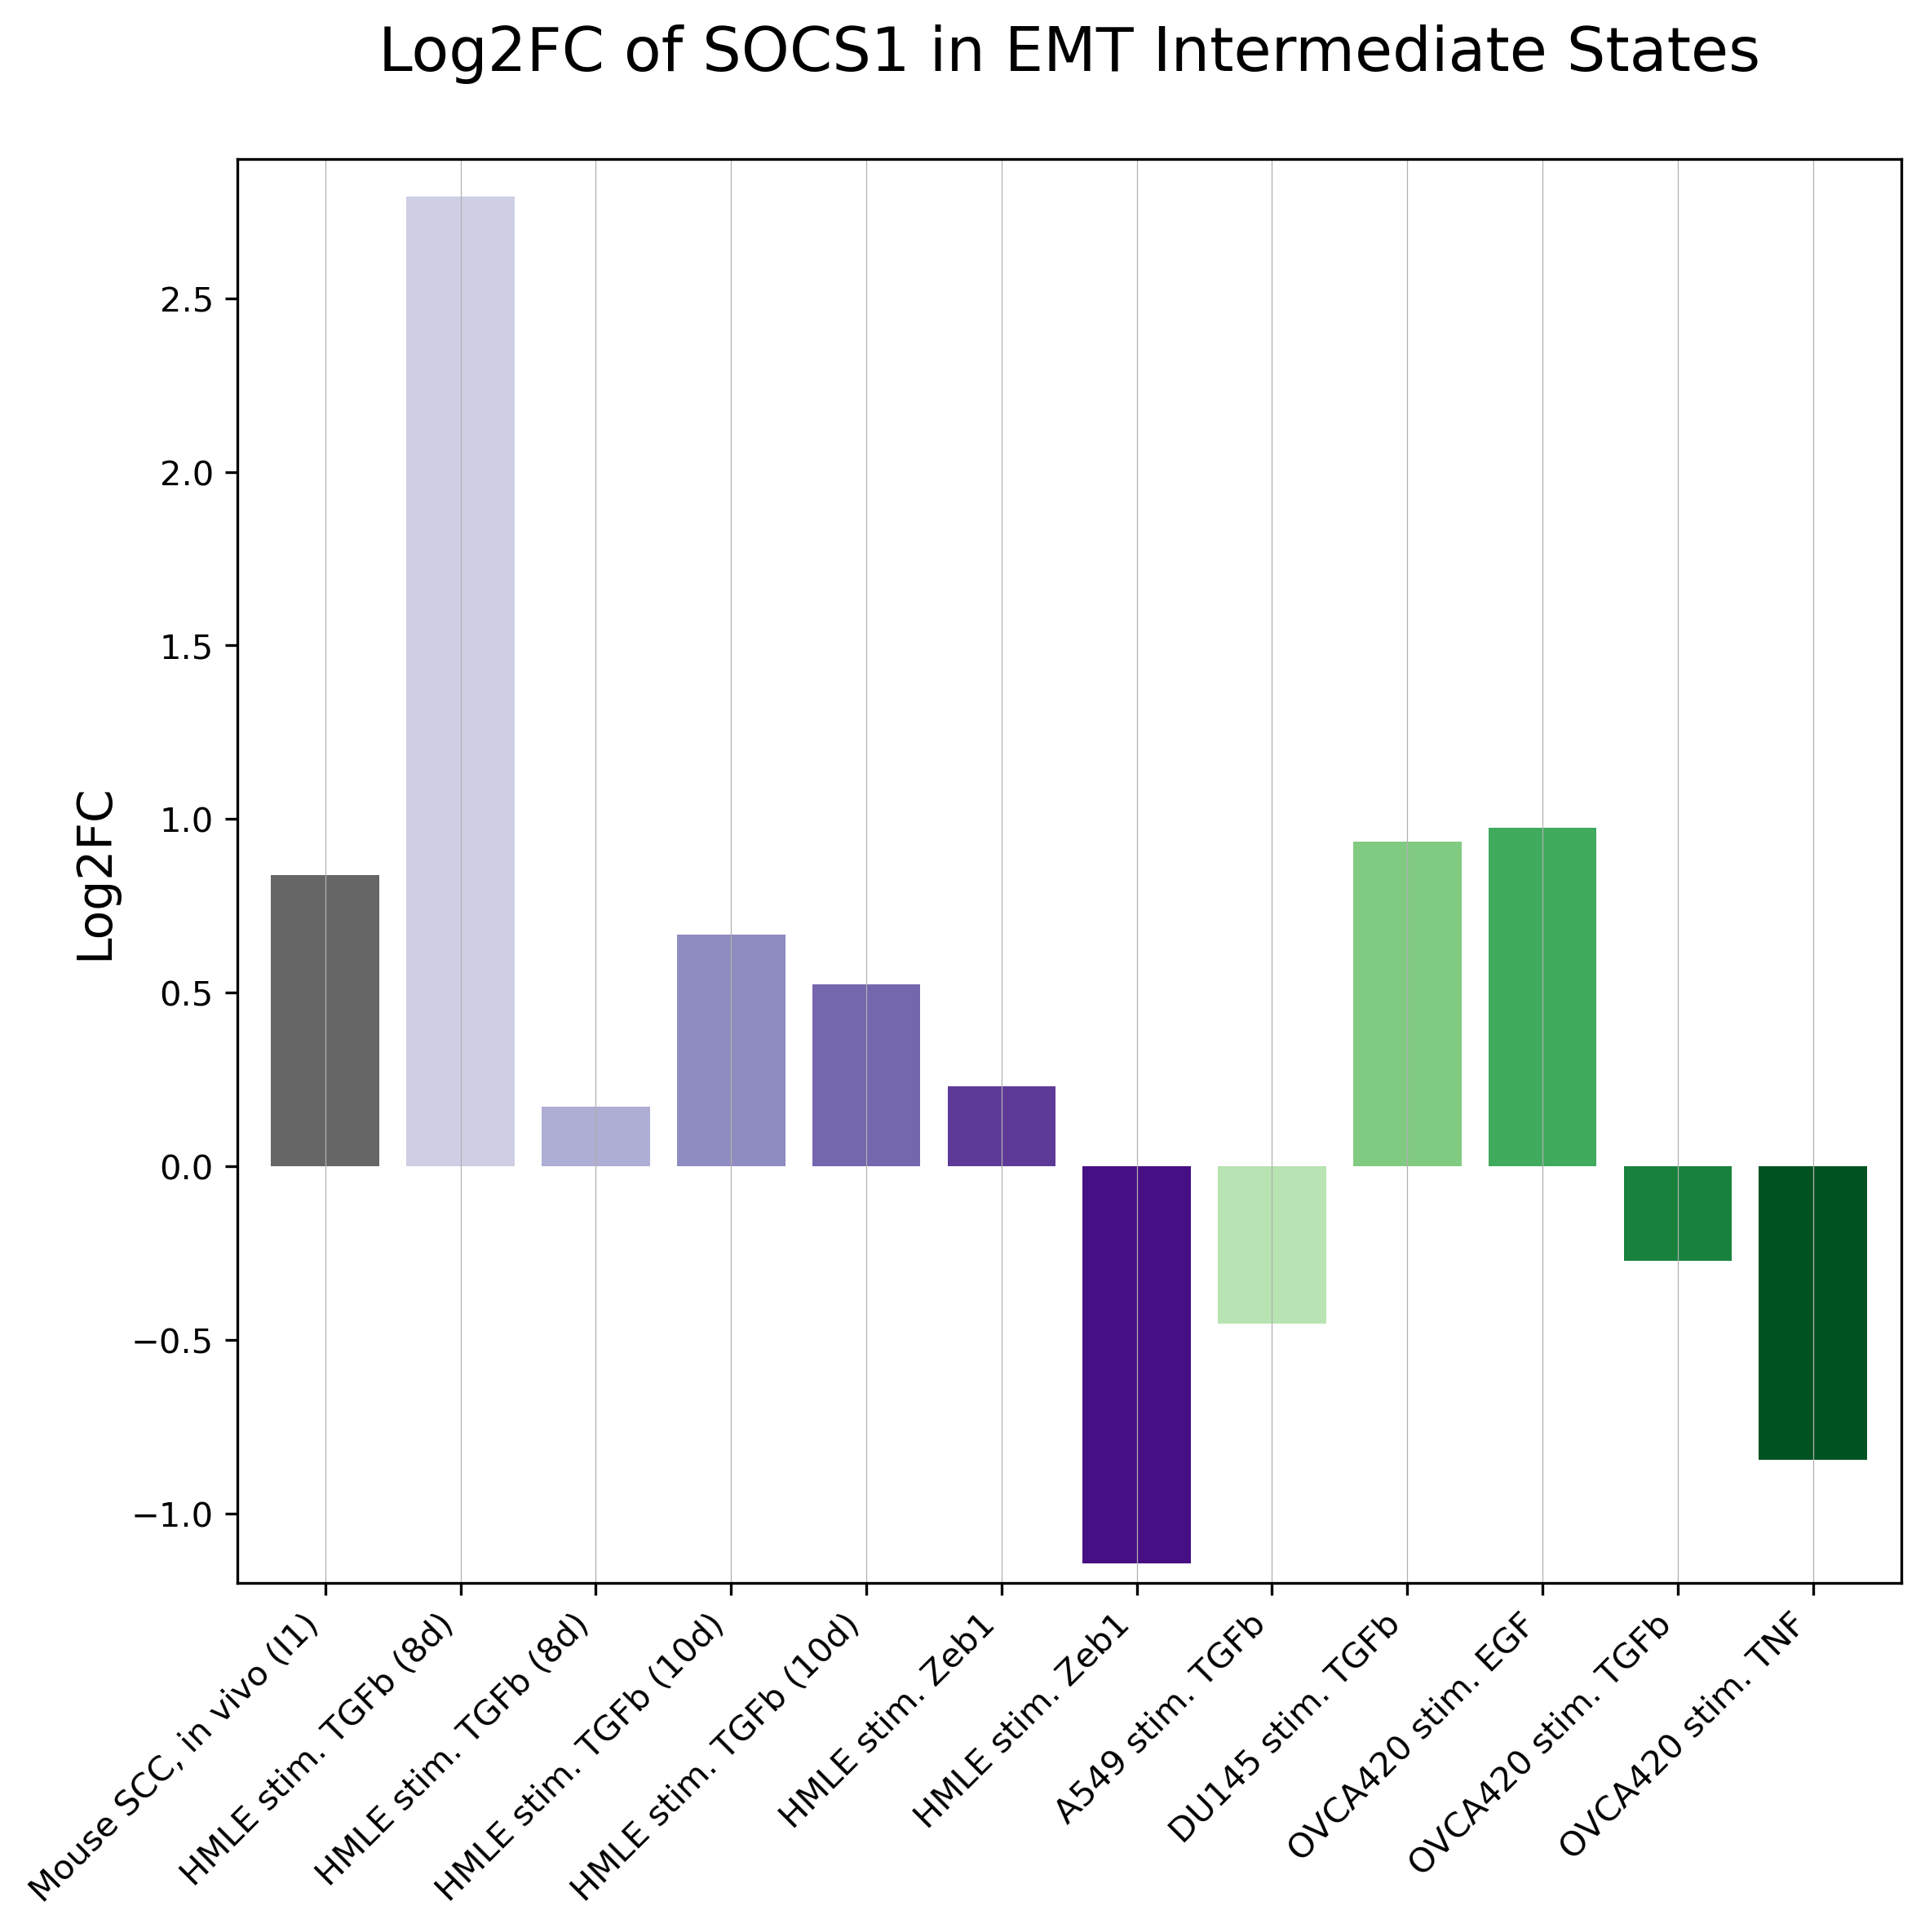

In [74]:
genes_fig2 = ["ITGA6", "SNCG", "WNT9A", "ITGB4", "SOCS1", "TNS4"]
plot_Log2FC_gene_svgOutput(genes_fig2[4])

In [89]:
# Function - graph bar plot of Log2FC for an input gene

# Drop the lower Pastushenko value
DE_genes_log2FC_columnsRenamed_svgOutput = DE_genes_log2FC_columnsRenamed.drop("Mouse SCC, in vivo (I2)", axis=1)

def plot_Log2FC_gene_svgOutput(currGene = "S100A2"):
    os.chdir(svgDir)
    
    # Custom markers
    black_1_value = [(0.4, 0.4, 0.4, 1.)]
    purple_6_values = plt.get_cmap('Purples')(np.linspace(0.3, 0.95, 6))
    purple_6_values_tuples = list(map(tuple, purple_6_values))
    green_5_values = plt.get_cmap('Greens')(np.linspace(0.3, 0.95, 5))
    green_5_values_tuples = list(map(tuple, green_5_values))
    colors_all = black_1_value + purple_6_values_tuples + green_5_values_tuples
    
    plt.figure(figsize = (8,8), dpi=300)
    ax = DE_genes_log2FC_columnsRenamed_svgOutput.loc[currGene].plot(kind='bar', color=colors_all, width=0.8, align='center')
    # Custom funtion to add "NE"
    add_value_labels(ax, DE_genes_log2FC_columnsRenamed_svgOutput.loc[currGene])
    plt.grid(axis='x', linewidth=0.3)
    plt.title("Log2FC of "+currGene+" in EMT "+currState+" States\n", fontsize=18)
    plt.ylabel("Log2FC", fontsize=14)
    plt.xticks(rotation=45, ha="right")
    ax.set_ylim([-0.65, 1.55])
    plt.tight_layout()
    # plt.show()
    # plt.savefig(currGene+" Histogram of Log2FC.png")
    # plt.close("all");
    plt.savefig("figure-5c-"+currGene+".svg")

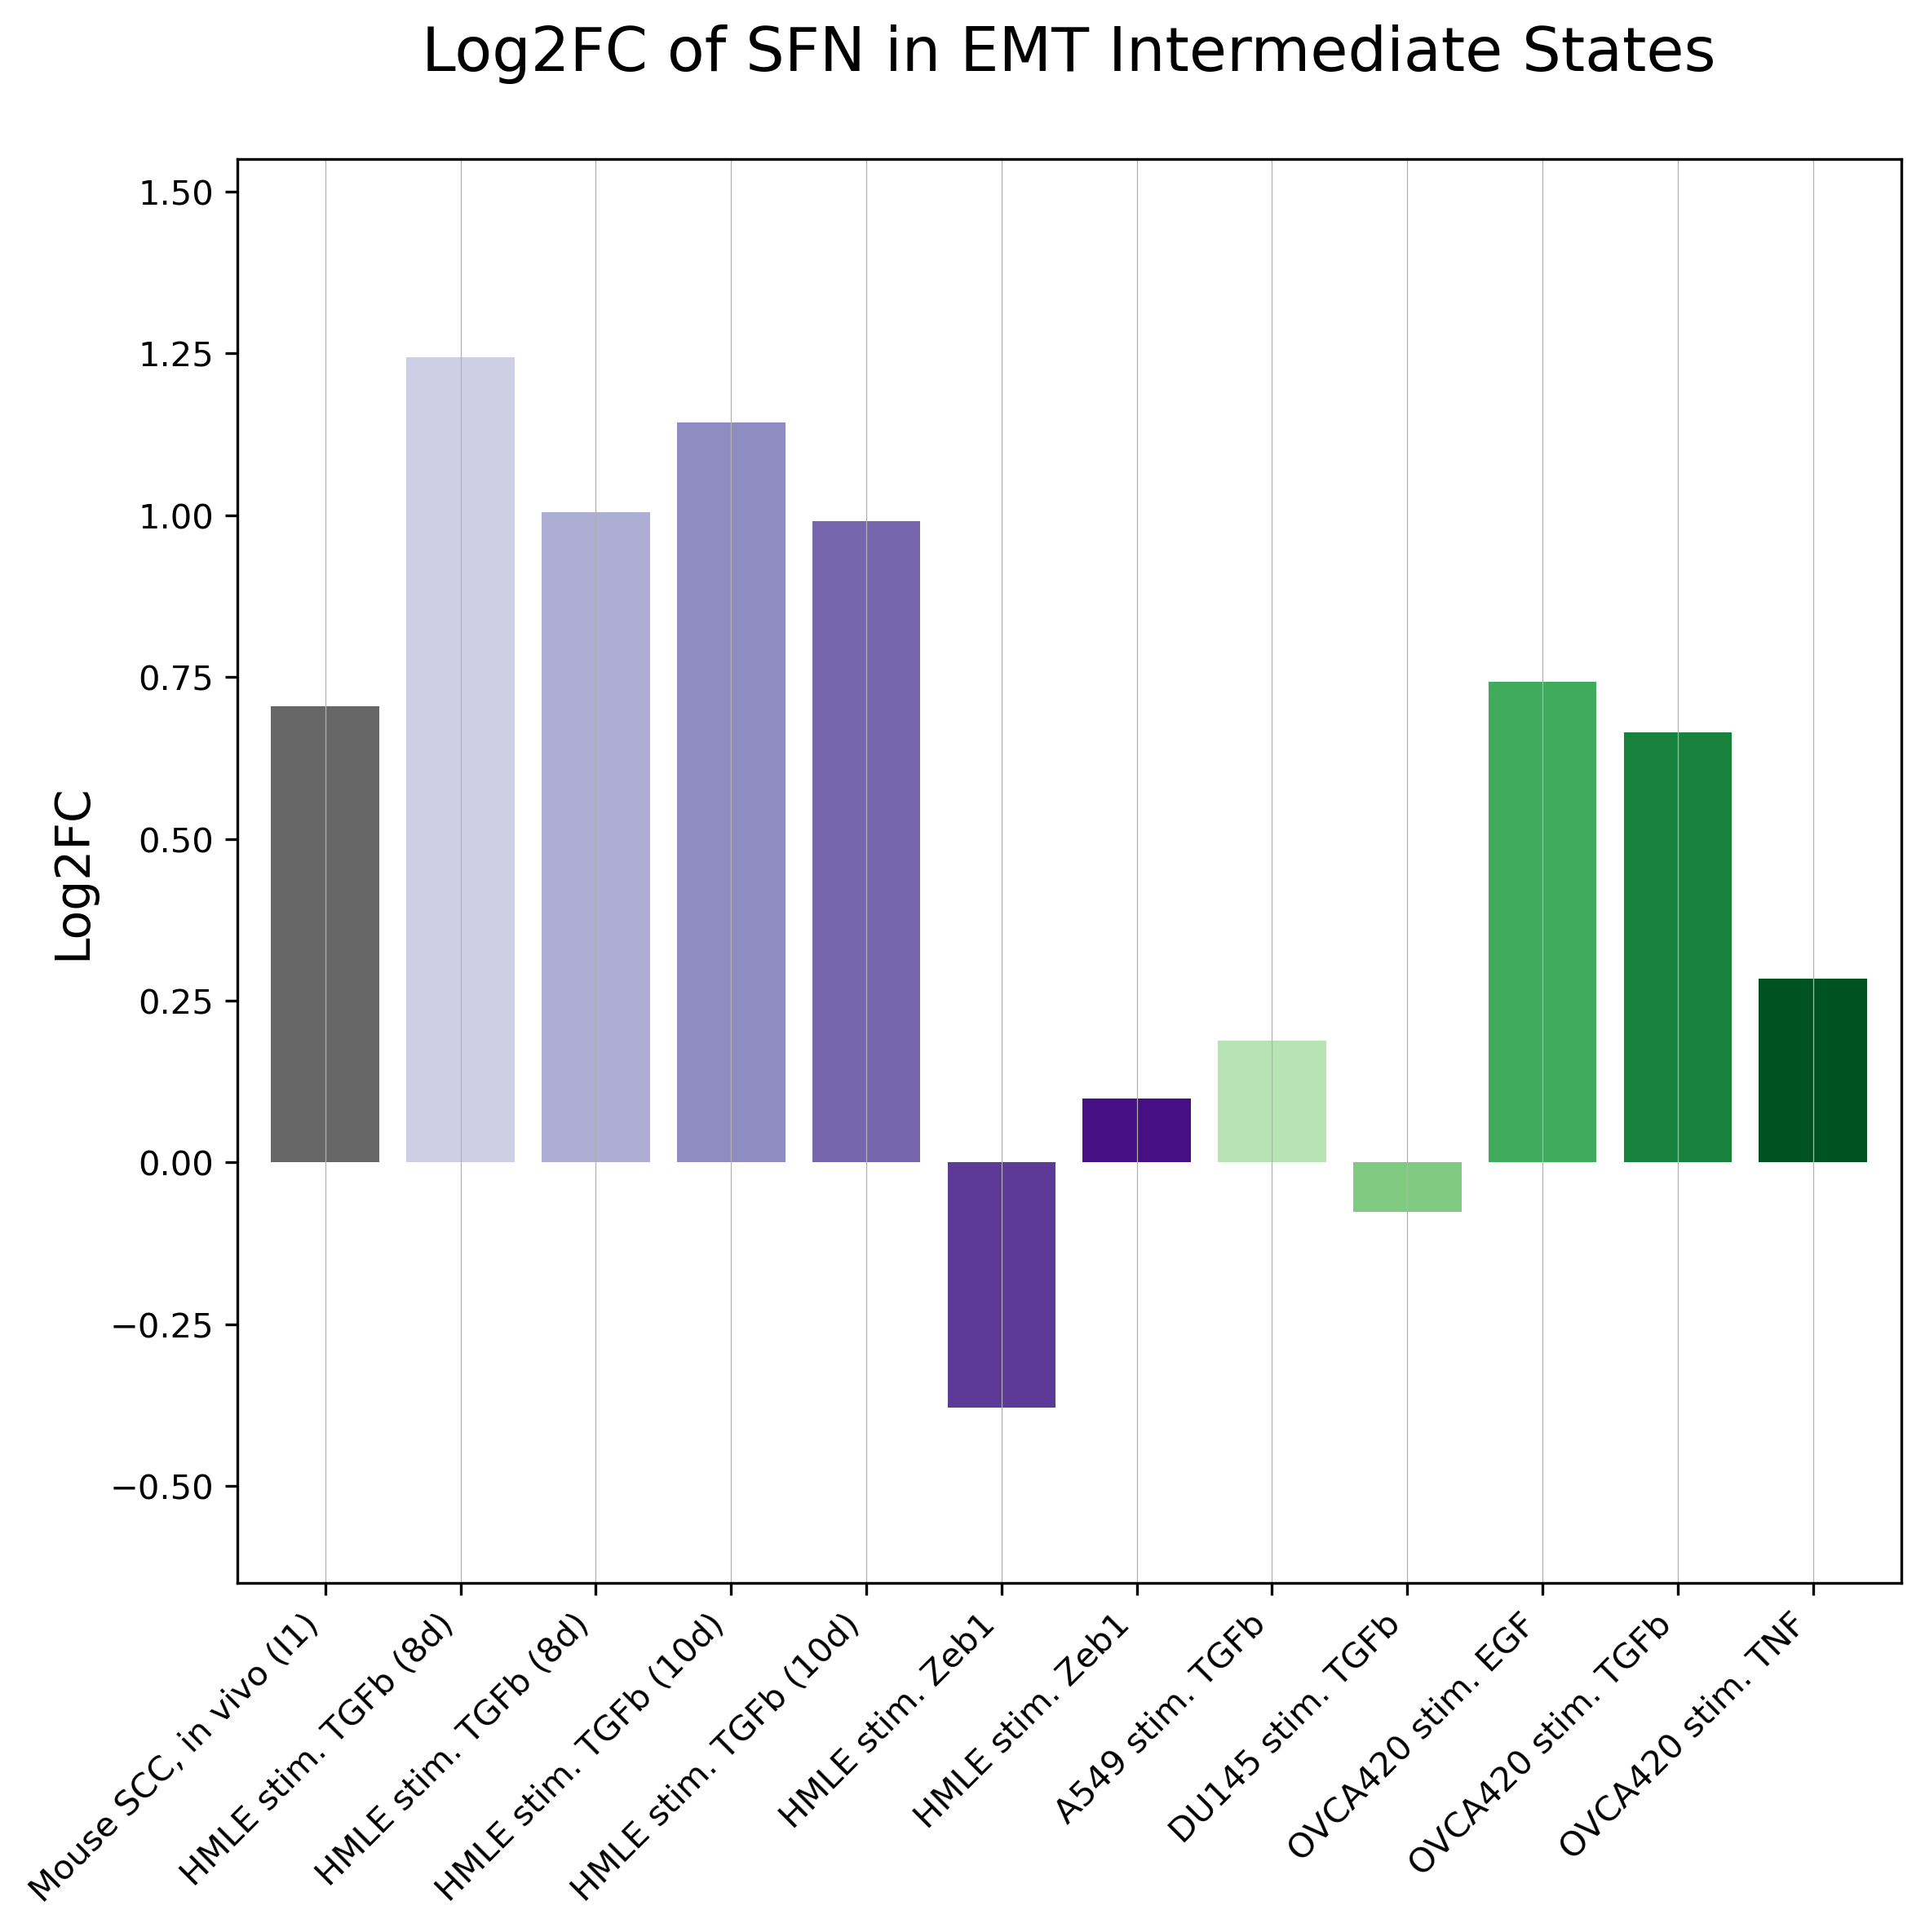

In [91]:
genes_fig5 = ["NRG1", "SFN"]
plot_Log2FC_gene_svgOutput(genes_fig5[1])